# Import Package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm


# Lunar Lander environment

In [2]:
seed = 543
def fix(env, seed):
    env.action_space.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
import gymnasium as gym
import random
env = gym.make('LunarLander-v2' ,render_mode='rgb_array')
fix(env, seed) # fix the environment Do not revise this !!!

In [3]:
initial_state = env.reset()
print(initial_state)


(array([ 1.2277603e-03,  1.4206719e+00,  1.2434329e-01,  4.3341199e-01,
       -1.4158564e-03, -2.8165620e-02,  0.0000000e+00,  0.0000000e+00],
      dtype=float32), {})


random policy

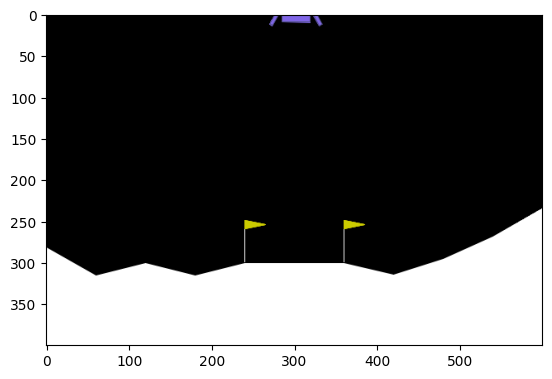

In [4]:
env.reset()

img = plt.imshow(env.render())

# done = False
# rewards = []
# for i in range(5):
#     env.reset()[0]
#     img = plt.imshow(env.render())
#     total_reward = 0
#     done = False
#     while not done:
#         action = env.action_space.sample()
#         observation, reward, done, _ , _= env.step(action)
#         # print(observation[0])
#         total_reward += reward
#         img.set_data(env.render())
#         display.display(plt.gcf())
#         display.clear_output(wait=True)
#     rewards.append(total_reward)

# PPO Agent

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Class: Memory

store the actions, states, rewards, is_termminal, and log probabilities

In [6]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

## Class: ActorCritic

### 2 fully connected networks
1. actor/action layer: input the states, follow the policy and yields an action
2. critic/value layer: input the states, evaluate the current ? //TODO

### act function

Generate a probability distribution of the actions using action layer taking state as the input, sample one action and store these information in the memory.

### evaluate function

Take a state as input and generate action probability distribution, calculate the entropy of this distribution and evaluate the log probability of the given action. Use the critic to evaluate the expected rewards under current state. Return all these values.

In [7]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, n_latent_var):
        super(ActorCritic, self).__init__()

        # actor
        self.action_layer = nn.Sequential(
                nn.Linear(state_dim, 128),
                nn.ReLU(),
                nn.Linear(128, n_latent_var),
                nn.ReLU(),
                nn.Linear(n_latent_var, action_dim),
                nn.Softmax(dim=-1)
                )

        # critic
        self.value_layer = nn.Sequential(
               nn.Linear(state_dim, 128),
               nn.ReLU(),
               nn.Linear(128, n_latent_var),
               nn.ReLU(),
               nn.Linear(n_latent_var, 1)
               )
    
    def act(self, state, memory):
        state = torch.from_numpy(state).float().to(device)
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        action = dist.sample()

        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))

        return action.item()

    def evaluate(self, state, action):
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()

        state_value = self.value_layer(state)

        return action_logprobs, torch.squeeze(state_value), dist_entropy

## PPOAgent

### gamma

if close to 1, future rewards will be considered more
if close to 0, current rewards wiil take more proportion

### state_values

the output of the critic, which evaluates the state and give an expected future reward

### rewards

the static list of discounted rewards calculated by the data in old trajectory (when adopting old policy)

### advantages = rewards - state_values.detach()

how better the old policy perform than current policy. if positive, actual reward is higher than state value, it is better to stick to current action, vice versa

In [8]:
class PPOAgent:
    def __init__(self, state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip, c1, c2):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.timestep = 0
        self.memory = Memory()

        self.policy = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        self.policy_old = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()
        self.update_cnt = 0

        self.c1 = c1
        self.c2 = c2


    def update(self):   
        # Monte Carlo estimate of state rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.memory.rewards), reversed(self.memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards:
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)

        # convert list to tensor
        old_states = torch.stack(self.memory.states).detach().to(device)
        old_actions = torch.stack(self.memory.actions).detach().to(device)
        old_logprobs = torch.stack(self.memory.logprobs).detach().to(device)

        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values 
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss 
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages # clip to avoid large difference between samples
            loss = -torch.min(surr1, surr2)  + self.c1*self.MseLoss(state_values, rewards) + self.c2*dist_entropy

            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.memory.clear_memory()
        # self.timstamp = 0

    def step(self, reward, done):
        self.timestep += 1 
        # Saving reward and is_terminal:
        self.memory.rewards.append(reward)
        self.memory.is_terminals.append(done)

        # update the policy per "update_timestep"
        if self.timestep % update_timestep == 0:
            self.update()
            self.memory.clear_memory()
            self.timstamp = 0
            self.update_cnt += 1

    def act(self, state):
        return self.policy_old.act(state, self.memory)
    
    def train(self):
        self.policy.train()
        self.policy_old.train()

    def eval(self):
        self.policy.eval()
        self.policy_old.eval()

In [9]:
def reward_shaping(pre_state, state, type):
    if (type == "center"):
        pre_shaping = -20*np.abs(pre_state[0])
        shaping = -20*np.abs(state[0])
    if (type == "horizontal"):
        pre_shaping = -1*np.abs(pre_state[4])
        shaping = -1*np.abs(state[4])
    if (type == "both"):
        pre_shaping = -10*np.abs(pre_state[0])-5*abs(pre_state[4])
        shaping = -10*np.abs(state[0])-5*abs(state[4])
    if (type == "none"):
        pre_shaping, shaping = 0, 0
    return shaping - pre_shaping
    
def moving_average(total_rewards):
    if len(total_rewards) == 0:
        return 0
    if len(total_rewards) < 99:
        return np.mean(total_rewards)
    else:
        return np.mean(total_rewards[-100:])

## Train Agent

In [10]:
# env
state_dim = 8 
action_dim = 4 
# Hyper parameters
n_latent_var = 64
update_timestep = 1000
c1 = 0.5
c2 = -0.006
# Adam
lr = 0.003                 
betas = (0.9, 0.999)
# discount factor, consider far away
gamma = 0.99
# update policy for K epochs
K_epochs = 4
# clip parameter for PPO
eps_clip = 0.22
random_seed = 1
reward_shaping_type = "center"# "both" "horizontal" "center" "none"

agent = PPOAgent(state_dim ,action_dim,n_latent_var,lr,betas,gamma,K_epochs,eps_clip,c1,c2)
agent.train()  # Switch network into training mode

total_rewards = []
final_rewards = []
moving_average_rewards = []
n = 0
while(moving_average(total_rewards)<200):
    n += 1
    state = env.reset()[0]
    total_reward = 0
    total_shaped_reward = 0
    update_cnt = agent.update_cnt
    step = 0
    # collect trajectory
    while True:
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        shaped_reward = reward + reward_shaping(state, next_state, reward_shaping_type) # try to manually control the behavior
        state = next_state
        total_shaped_reward += shaped_reward # use the shaped reward to train
        total_reward += reward
        agent.step(shaped_reward, done)
        step += 1
        if done or step>1000:
            final_rewards.append(reward)
            total_rewards.append(total_reward)
            break
    moving_average_rewards.append(moving_average(total_rewards))
    if (update_cnt != agent.update_cnt):
        print(f"Update Count: {agent.update_cnt}, average rewards: {moving_average(total_rewards)}, episode: {n}")

Update Count: 1, average rewards: -202.31678463399393, episode: 11
Update Count: 2, average rewards: -189.11349141155483, episode: 24
Update Count: 3, average rewards: -166.84988879328617, episode: 34
Update Count: 4, average rewards: -161.91222368271727, episode: 47
Update Count: 5, average rewards: -157.76466818799366, episode: 58
Update Count: 6, average rewards: -165.55360079133197, episode: 70
Update Count: 7, average rewards: -170.16141897517346, episode: 80
Update Count: 8, average rewards: -166.2094419802394, episode: 90
Update Count: 9, average rewards: -163.20492003221608, episode: 100
Update Count: 10, average rewards: -151.96265097065876, episode: 110
Update Count: 11, average rewards: -146.3987323778482, episode: 120
Update Count: 12, average rewards: -147.04862186890753, episode: 130
Update Count: 13, average rewards: -148.51663088257735, episode: 140
Update Count: 14, average rewards: -149.04090839130902, episode: 148
Update Count: 15, average rewards: -153.1926170919918

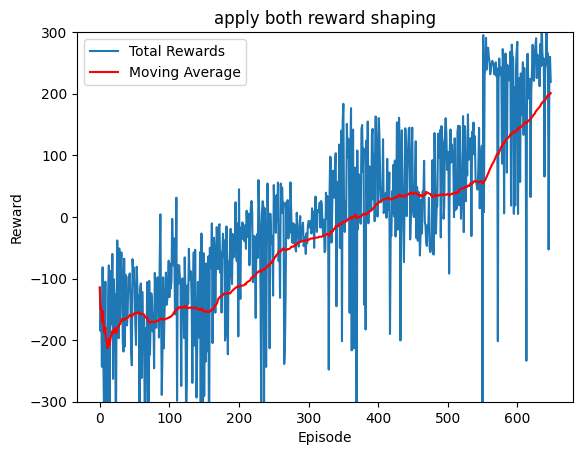

In [11]:
# store the result
import pickle

data = {'total_rewards': total_rewards, 'final_rewards': final_rewards, 'moving_average_rewards': moving_average_rewards}

with open(f'reward_shaping_center_20.pkl', 'wb') as f:
    pickle.dump(data, f)
    
with open(f'reward_shaping_center_20.pkl', 'rb') as f:
    data = pickle.load(f)
total_rewards = data['total_rewards']
final_rewards = data['final_rewards']
moving_average_rewards = data['moving_average_rewards']

plt.title('apply both reward shaping')
plt.plot(total_rewards, label='Total Rewards')
plt.plot(moving_average_rewards, color='red', label='Moving Average')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.ylim(-300, 300)
plt.show()

ImportError: Imageio Pillow requires Pillow, not PIL!

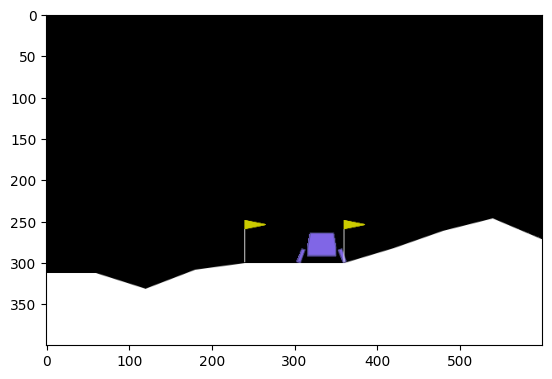

In [12]:
import imageio
gif = []
fix(env, seed)
agent.eval()
actions = []
state = env.reset()[0]
img = plt.imshow(env.render())
total_reward = 0
done = False
step = 0
while not done :
    step +=1
    action = agent.act(state)
    actions.append(action)
    state, reward, done, _, _ = env.step(action)
    total_reward += reward
    img.set_data(env.render())
    gif.append(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

imageio.mimsave('reward_shaping_horizontal.gif', gif, fps=30)    

In [ ]:
print(total_reward)

In [ ]:
fix(env, seed)
agent.eval()
test_total_rewards = []
test_final_rewards = []
step_used_list = []
prg_bar = tqdm(range(100))
for i in prg_bar:
# for i in range(200):
    actions = []
    state = env.reset()[0]
    # img = plt.imshow(env.render())
    total_reward = 0
    done = False
    step = 0
    while not done :
        step +=1
        action = agent.act(state)
        actions.append(action)
        state, reward, done, _, _ = env.step(action)
        total_reward += reward
        # img.set_data(env.render())
        # display.display(plt.gcf())
        # display.clear_output(wait=True)
    test_total_rewards.append(total_reward)
    test_final_rewards.append(reward)
    step_used_list.append(step)

In [ ]:

plt.plot([i for i in range(100)],test_total_rewards)
plt.ylim(-300,350)
plt.scatter([i for i in range(100)],test_final_rewards,c='r')
print(test_final_rewards.count(100))

In [ ]:
print(np.mean(test_total_rewards))